# Testing state abstraction on Ott's data with Ott's model

In the previous notebook, we have tested the abstractions models with a simple hierarchical logistic regression. However, Ott et al. used a more sophisticated model to take into account specific edge cases in their data. It is possible that the fact that the model without abstraction wins over others because it has a slight advantage in these specific edge cases in which the fit is actually poor. It could therefore be the case that fitting Ott's planning model reveals that the abstraction fits the data better after these edge cases have been accounted for. This is what we will test. 

## Compute pairwise distances:

In [11]:
import numpy as np
import pandas as pd
import os
from scipy.stats import zscore
from stabst.utils import plot_state_matrix, beh_barplot, abstract2ground_value
from scipy.special import expit
from stabst.MarkovDecisionProcess import MDP
from stabst.TaskConfig import LimitedEnergyTask
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import arviz as az
import pymc as pm

# ===================================================================================
# Prepare the data:
# Download data from Florian's repo:
data = pd.read_csv("../data/raw_data/all_participants_data.csv", on_bad_lines='skip')
# Remove nans:
data = data.dropna()
# Flip responses: 1 = accept:
data["response"] = np.abs(data["response"] - 1)
# Make trial 1 based
data["trial"] = data["trial"] + 1
# Remove the 
# Get subject IDs:
subj_idx_raw, subj_labels = pd.factorize(data["vpn"])
coords = {
    "observation": np.arange(len(data)),
    "subject": subj_labels,
}

transitions_costs = {
    0: [1, 1],
    1: [2, 1],
    2: [1, 2],
    3: [2, 2]
}
data["fc"] = [transitions_costs[row["transition"]][1] for _, row in data.iterrows()]

In [12]:
# Create the task and its parameters (transition probability, reward...):
task = LimitedEnergyTask(O=[1, 2, 3, 4], p_offer=[1/4] * 4)
task.build()

# Create full MDP and compute solution for later reference:
gamma = 0.99
task_mdp = MDP(task.states, task.tp, task.r, gamma, s2i=task.s2i)
V_full, Q_full = task_mdp.backward_induction()
R_full = task_mdp.expected_return(task_mdp.greedy_policy(Q_full), initial_energy=3)

# Compute pairwise distances:
if not os.path.isfile(f'../data/bids/limited_energy/derivatives/state_abstraction/bisimulation_distance_matrix_gamma_{gamma}.npy'):
    distances_matrix = task_mdp.bisim_metric(gamma=0.99, tol=1e-3, njobs=-1, max_iters=1000)
    distances_matrix = distances_matrix / np.max(distances_matrix)
    if not os.path.isdir("../data/bids/limited_energy/derivatives/state_abstraction"):
        os.makedirs("../data/bids/limited_energy/derivatives/state_abstraction")
    np.save(f'../data/bids/limited_energy/derivatives/state_abstraction/bisimulation_distance_matrix_gamma_{gamma}.npy', distances_matrix)
else:
    distances_matrix = np.load(f'../data/bids/limited_energy/derivatives/state_abstraction/bisimulation_distance_matrix_gamma_{gamma}.npy')

# Compute decision values for each abstraction level:

In [13]:
unique_dist = np.unique(np.round(distances_matrix, decimals=3))
n_states = len(task_mdp.states)
abstraction_distances = []
DVs = []

for eps in unique_dist: #unique_dist:
    # Generate abstracted MDP at that level of abstraction:
    abstract_mdp, state_classes, class_of_state = task_mdp.distance_reduce_mdp(eps + 0.0001, distance_matrix=distances_matrix)
    if n_states - len(abstract_mdp.states) < 10:
        continue
    else:
        n_states = len(abstract_mdp.states)
        abstraction_distances.append(eps)
    # Solve the MDP:
    V_R, Q_R = abstract_mdp.backward_induction()
    # Project back to Ground space:
    V_from_abstract, Q_from_abstract = abstract2ground_value(class_of_state, V_R, Q_R)
    # Add to decision values
    DVs.append(zscore(Q_from_abstract[:, 1] - Q_from_abstract[:, 0]))

## Specfiy model:

In [14]:
# Add the decision value associated with each epsilons:
for eps_i, eps in enumerate(abstraction_distances):
    # Get the decision value:
    dv = DVs[eps_i]
    # Loop through each trial to set DV:
    dv_trials = []
    mdl_sim_resps = []
    decision_match = []
    for trial_i, trial in data.iterrows():
        e, o, cc, t = trial.energy, trial.reward, trial.energy_cost, trial.trial
        fc = transitions_costs[trial.transition][1]
        dv_trials.append(dv[task.s2i[(e, o, cc, fc, t)]])
        # Simulate data according to that plan:
        mdl_sim_resps.append(np.random.binomial(1, expit(dv[task.s2i[(e, o, cc, fc, t)]])))
        decision_match.append(1 - np.abs(trial.response - mdl_sim_resps[-1]))
    data[f'DV-eps: {eps}'] = dv_trials


In [15]:
# Extract the data of one subject:
subj_idx_raw, subj_labels = pd.factorize(data["vpn"])
coords = {
    "subject": subj_labels,
    "coef": ["beta_plan", "beta_basic", "beta_maxE", "beta_mineE_LC", "beta_mineE_HC"],
}

with pm.Model(coords=coords) as hierarchical_binomial_regression:
    y_obs = pm.Data("y_obs", data["response"])
    dv = pm.Data("Decision values", data[f"DV-eps: {0.0}"])
    is_basic = pm.Data("is_basic", data["is_basic"])
    is_maxE = pm.Data("is_maxE", data["is_full_energy"])
    is_minE_LC = pm.Data("is_minE_LC", data["is_low_energy_LC"])
    is_minE_HC = pm.Data("is_minE_HC", data["is_low_energy_HC"])
    subj_idx = pm.Data("subj_idx", subj_idx_raw)

    # Population level priors:
    beta_pop = pm.Normal("beta_pop", mu=0, sigma=2, dims="coef")
    sigma_pop = pm.HalfNormal('sigma_pop', sigma=2, dims="coef")
    # Non centered parametrization of within subject coefficients
    z = pm.Normal("z", 0, 1, dims=("subject", "coef"))
    beta_sub = pm.Deterministic("beta_sub", beta_pop + z * sigma_pop, dims=("subject","coef"))

    # Likelihood
    p = pm.Deterministic("p", 
                         pm.math.sigmoid(
                             beta_sub[subj_idx, 0] * dv +
                             beta_sub[subj_idx, 1] * is_basic +
                             beta_sub[subj_idx, 2] * is_maxE +
                             beta_sub[subj_idx, 3] * is_minE_LC +
                             beta_sub[subj_idx, 4] * is_minE_HC
                             ))
    pm.Bernoulli("y", p=p, observed=y_obs)



## Fit model:

In [16]:
# Model with each abstraction levels and sample:
traces = {}
for eps in abstraction_distances[0:7]:
    with hierarchical_binomial_regression:
        pm.set_data({"Decision values": data[f'DV-eps: {eps}']})
        traces[f'DV, eps={eps}'] =  pm.sample(1000, tune=1000, target_acceptance=0.95, idata_kwargs={"log_likelihood": True})
        data[f'p(y=1|y_obs)@eps={eps}'] = traces[f'DV, eps={eps}'].posterior.p.mean(dim=["chain", "draw"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.


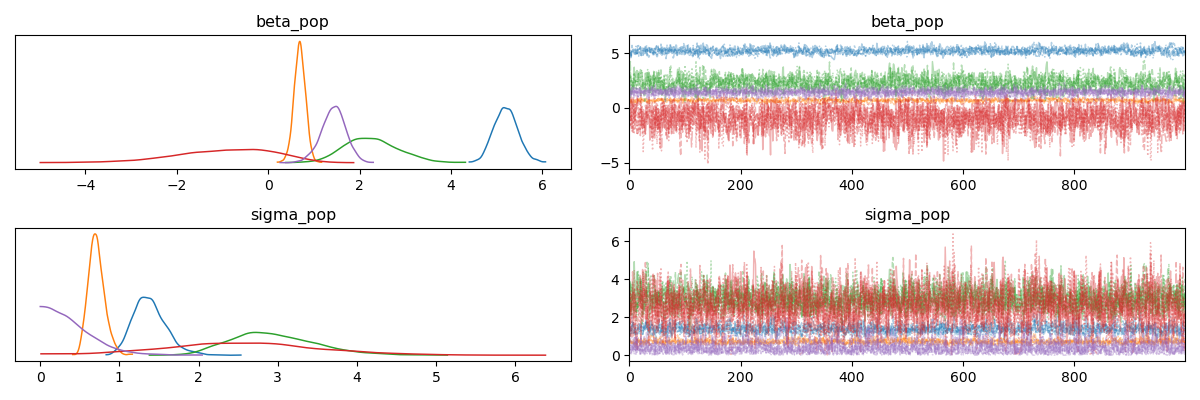

In [17]:
# plot the trace of the none abstracted model:
az.plot_trace(traces[f'DV, eps={0.0}'], var_names=["beta_pop", "sigma_pop"], combined=True)
plt.tight_layout()

# Model comparison:

/home/alex-lepauvre/miniforge3/envs/pymc_env/lib/python3.14/site-packages/arviz/stats/stats.py:782: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/alex-lepauvre/miniforge3/envs/pymc_env/lib/python3.14/site-packages/arviz/stats/stats.py:782: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/alex-lepauvr

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

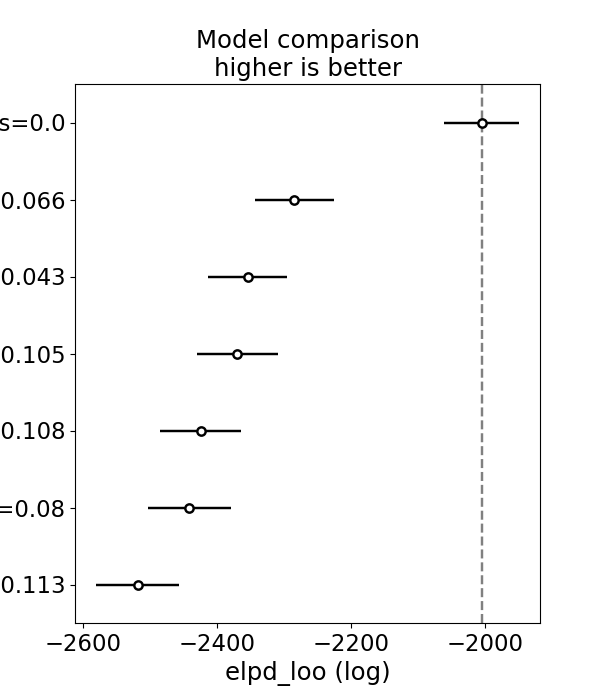

In [18]:
# Compare models:
model_comparison = az.compare(traces)
az.plot_compare(model_comparison)

Once again, we can see that the model without any abstractions performs at least as good as the abstracted models. Nonetheless, we can investigate the fit in every single condition. 

# Plotting the results:
To evalute the fit of the data, we will plot the data alongside the posterior, to evaluate how well each abstraction level is doing:

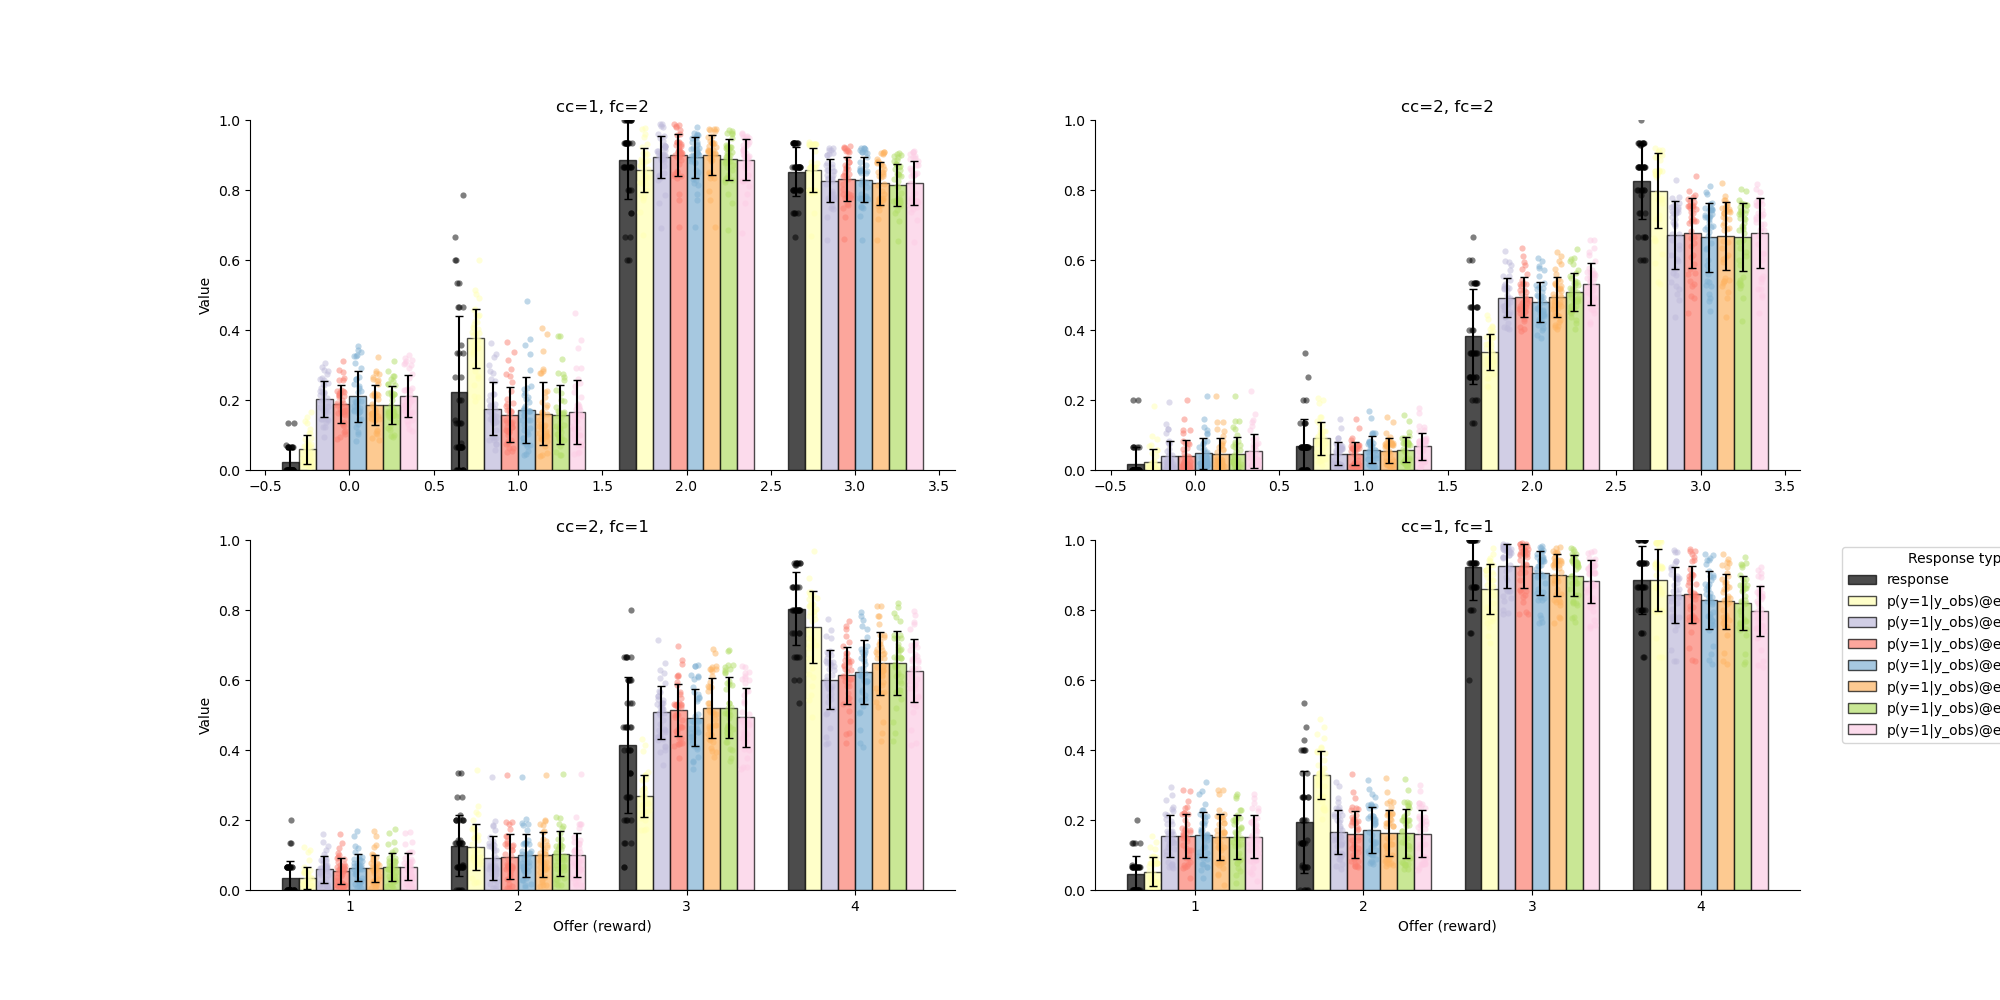

In [19]:
beh_barplot(data, abstraction_distances[0:7], transitions_costs, "p(y=1|y_obs)@eps=");

The plotting of the results go in the direction of the model comparison: the model without abstraction performs overall closest to the actual participants behaviours. But to be sure, let's have a look in more details in each condition:

(<Figure size 1200x800 with 17 Axes>,
 array([[<Axes: title={'center': 'Offer = 1'}, ylabel='cc=1, fc=1 \n Energy'>,
         <Axes: title={'center': 'Offer = 2'}>,
         <Axes: title={'center': 'Offer = 3'}>,
         <Axes: title={'center': 'Offer = 4'}>],
        [<Axes: ylabel='cc=1, fc=2 \n Energy'>, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='cc=2, fc=1 \n Energy'>, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: xlabel='Trials', ylabel='cc=2, fc=2 \n Energy'>,
         <Axes: xlabel='Trials'>, <Axes: xlabel='Trials'>,
         <Axes: xlabel='Trials'>]], dtype=object))

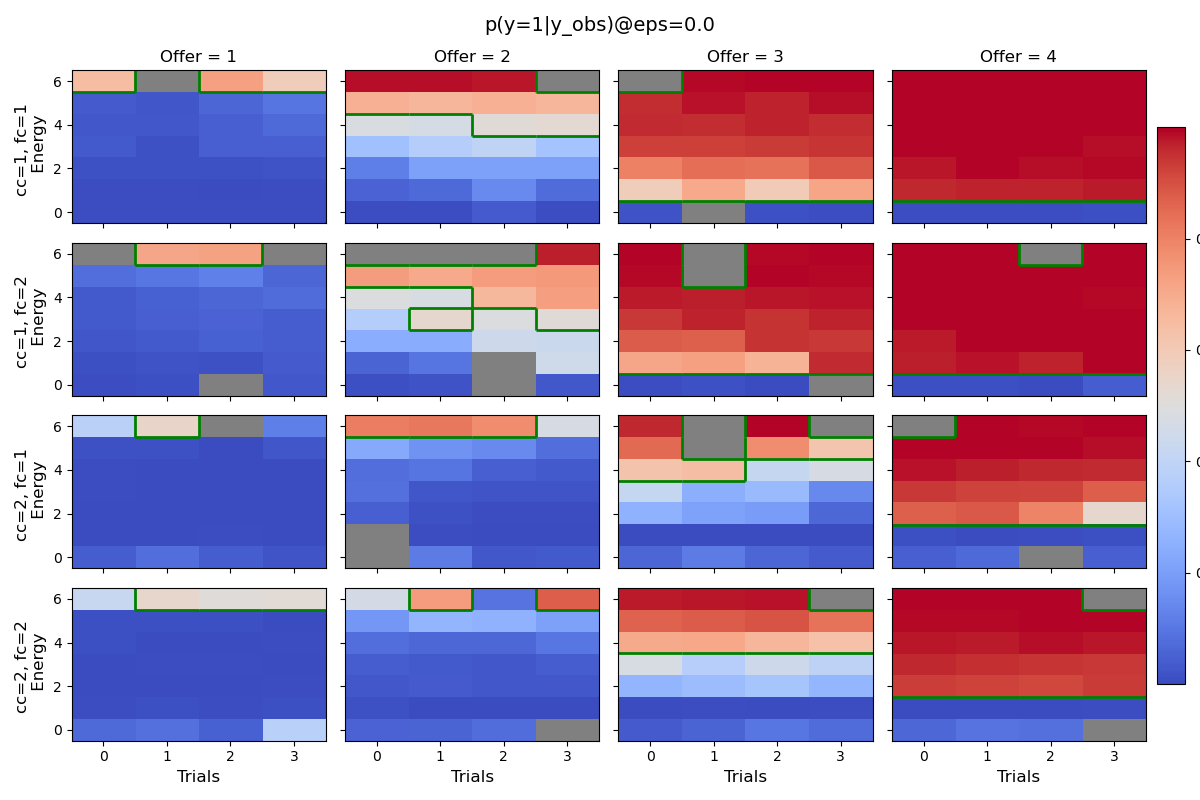

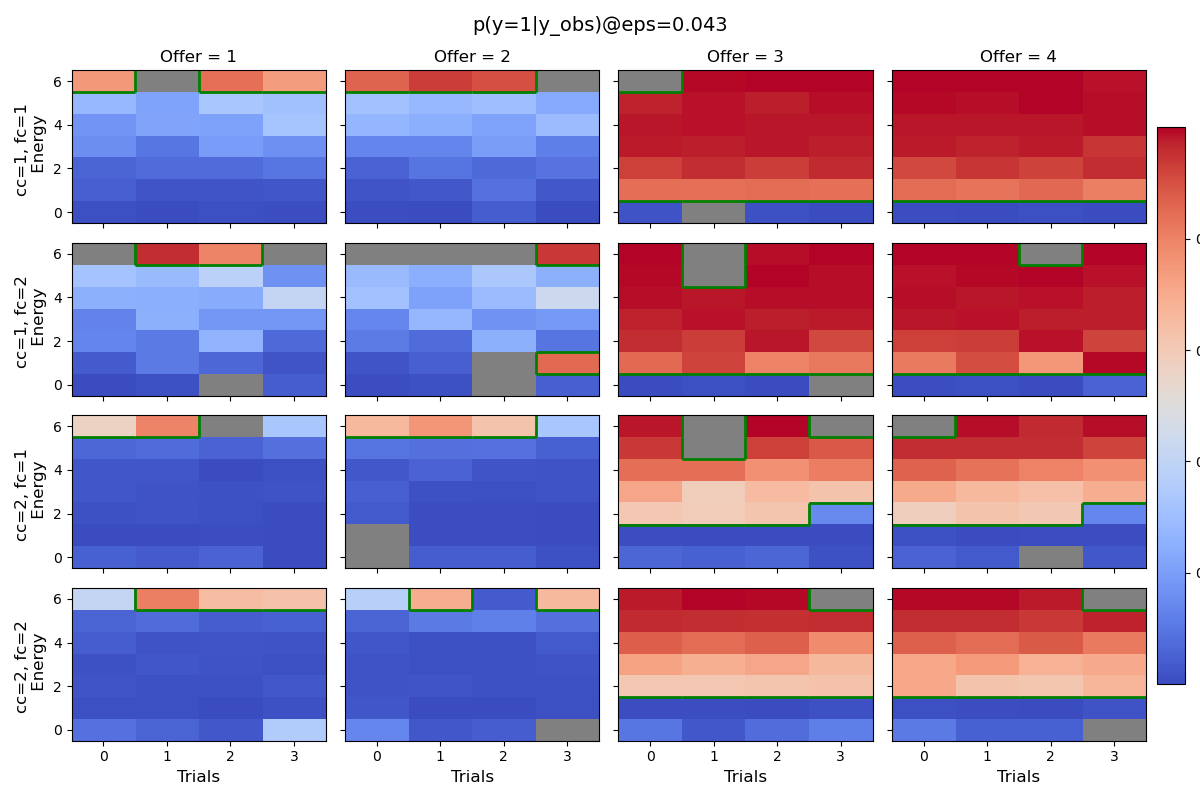

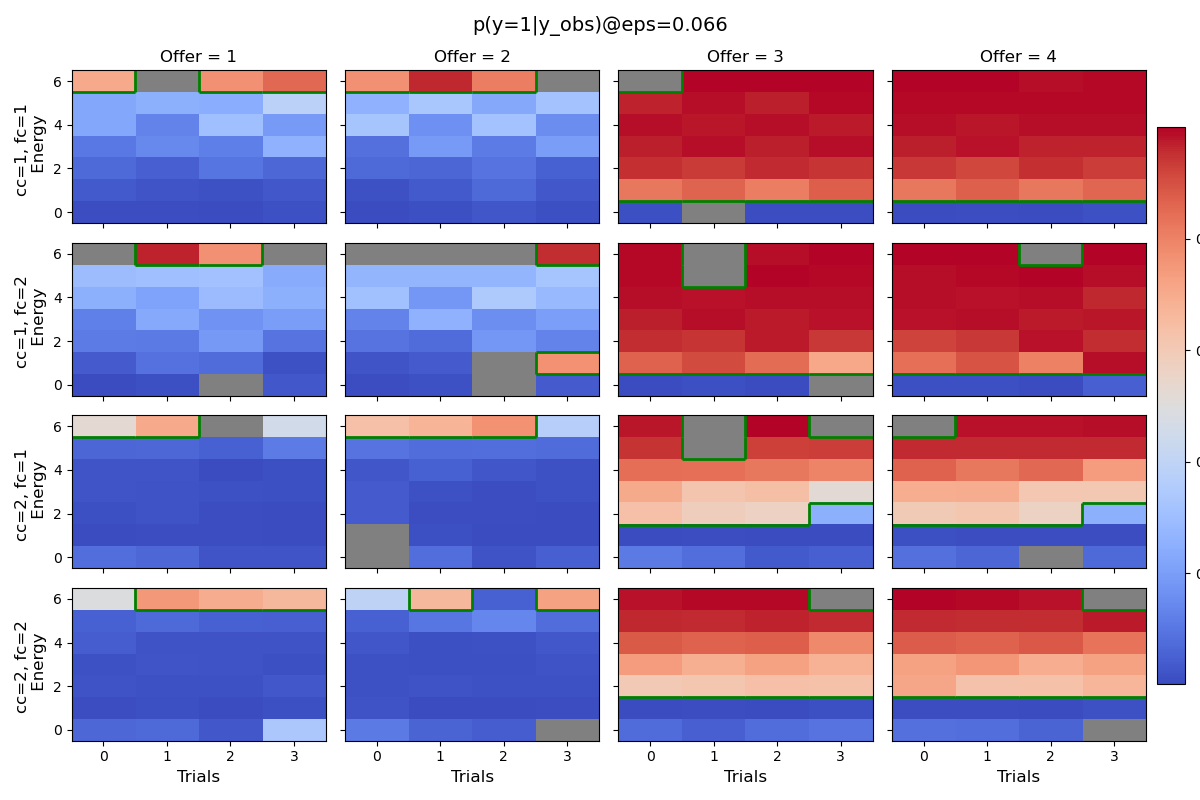

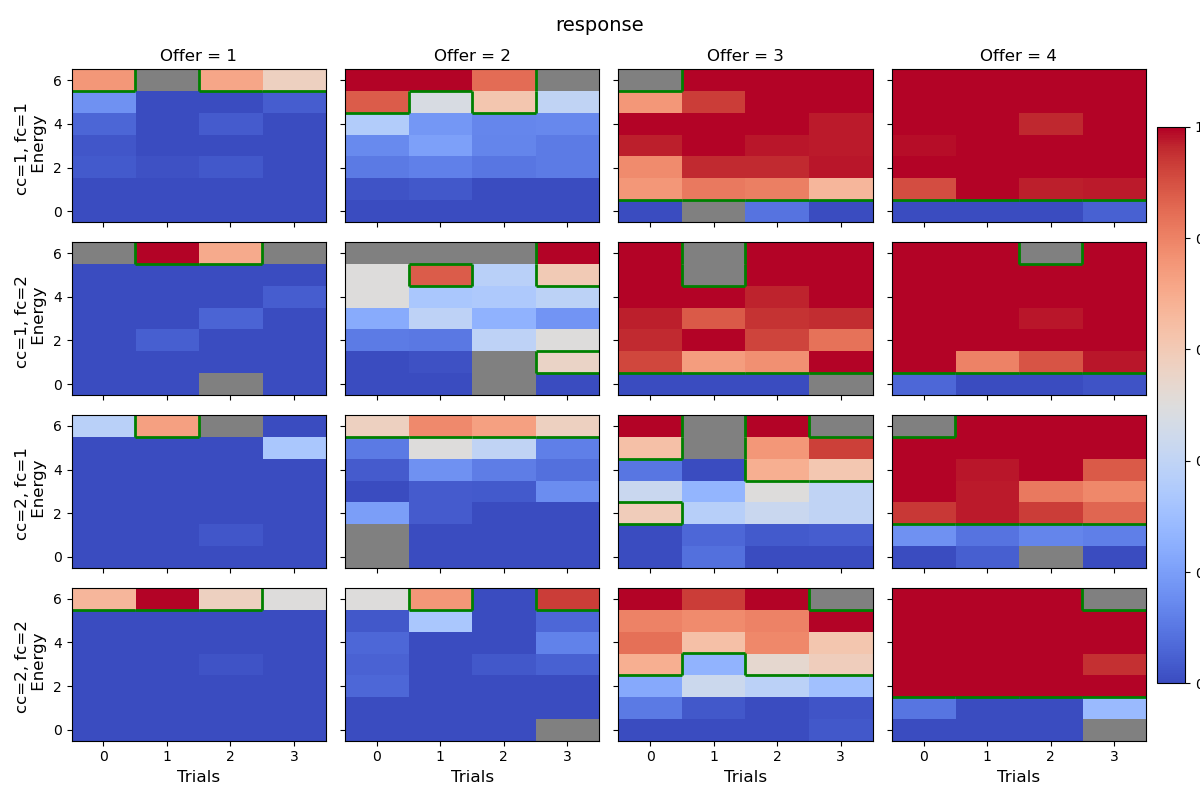

In [20]:
# Loop through each abstraction distances:
state_cols = ["energy", "reward", "energy_cost", "fc", "trial"]
cmap = plt.get_cmap('coolwarm')
cmap.set_bad("grey")
for eps in abstraction_distances[0:3]:
    mean_resp = np.empty(len(task_mdp.states))
    for state in task_mdp.states:
        mean_resp[task_mdp.s2i[*state]] = data.loc[(data[state_cols].to_numpy() == state).all(axis=1), f'p(y=1|y_obs)@eps={eps}'].mean()
    # Plot:
    task_mdp.plot_dv(mean_resp, title=f'p(y=1|y_obs)@eps={eps}', tmax=4, cmap=cmap, cmap_midpoint=0.5, boundary_threshold=0.5)

mean_resp = np.empty(len(task_mdp.states))
for state in task_mdp.states:
    mean_resp[task_mdp.s2i[*state]] = data.loc[(data[state_cols].to_numpy() == state).all(axis=1), 'response'].mean()
# Plot:
task_mdp.plot_dv(mean_resp, title='response', tmax=4, cmap=cmap, cmap_midpoint=0.5, boundary_threshold=0.5)